<>:149: SyntaxWarning: invalid escape sequence '\l'
<>:149: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_9116/2526809260.py:149: SyntaxWarning: invalid escape sequence '\l'
  plt.ylabel('Log Divergence $\langle \ln |d_j(k)| \\rangle$', fontsize=12)


=== Lyapunov 指数分析 (改进版) ===
计算发散曲线 (m=6)...


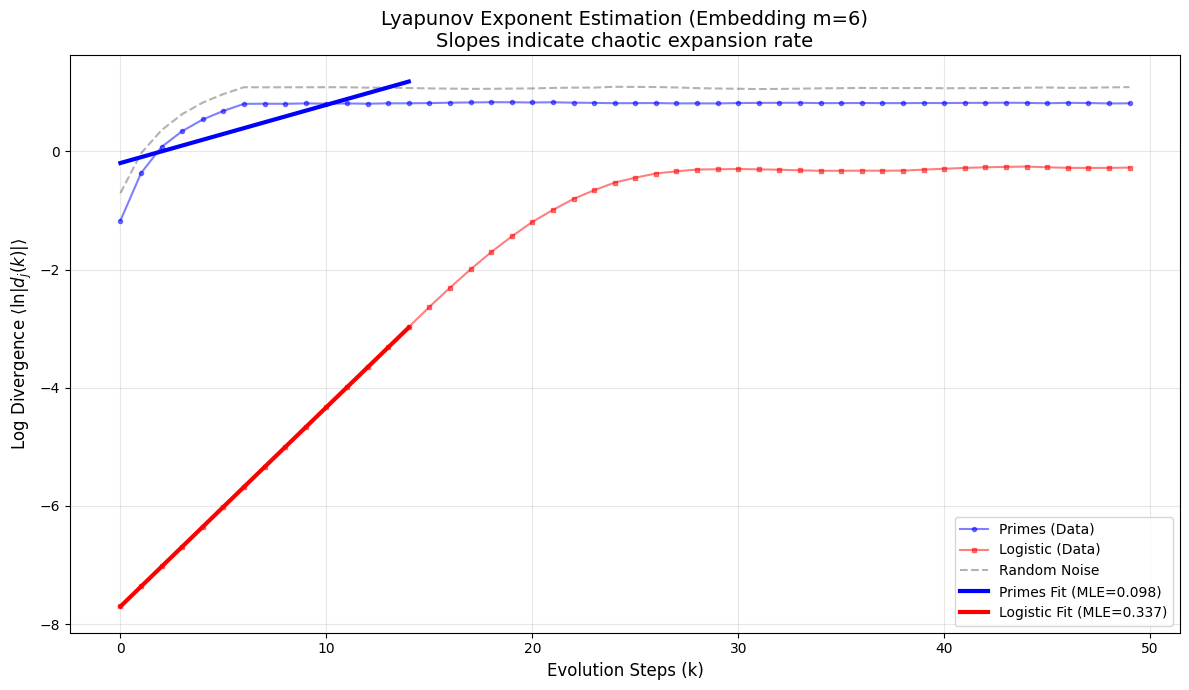

Logistic MLE: 0.3373
Primes   MLE: 0.0984
Random   MLE: 0.1762 (参考值，通常无意义)


In [2]:
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# 1. 参数设置与数据生成
# ==========================================
U_CRITICAL = 1.543689012692076 
DATA_LENGTH = 5000   
PRIME_LIMIT = 200_000  # 改进：增加数据量以稳定统计特性

def get_normalized_prime_gaps(limit):
    """生成并归一化的素数间隙序列"""
    sieve = np.ones(limit // 2, dtype=bool)
    for i in range(3, int(limit**0.5) + 1, 2):
        if sieve[i // 2]:
            sieve[i*i // 2 :: i] = False
    primes = np.array([1] + [2 * i + 1 for i in range(1, limit // 2) if sieve[i]])
    gaps = np.diff(primes)
    
    # 归一化：除以局部平均值 ln(p)
    p_vals = primes[:-1].astype(float)
    # 避免 p=1 时 log(1)=0 的问题，虽然筛法通常从2或3开始，加个安全检查
    p_vals[p_vals < 2] = 2 
    norm_gaps = gaps / np.log(p_vals)
    return norm_gaps

def get_logistic_trajectory(length, u):
    x = 0.1
    traj = []
    for _ in range(10000): # 预热
        x = 1 - u * x**2
    for _ in range(length):
        x = 1 - u * x**2
        traj.append(x)
    return np.array(traj)

# ==========================================
# 2. 改进版 Rosenstein 算法
# ==========================================
def calculate_divergence_curve(data, m=6, tau=1, window=60): # 改进：默认 m=6
    """
    只负责计算发散曲线，不进行盲目拟合。
    返回: avg_div_curve (平均对数发散曲线)
    """
    N = len(data)
    M_steps = N - (m - 1) * tau
    
    # A. 相空间重构
    X = np.zeros((M_steps, m))
    for i in range(m):
        X[:, i] = data[i*tau : i*tau + M_steps]
    
    # B. 寻找最近邻
    n_ref = min(3000, M_steps - window) # 稍微增加参考点
    div_curve = np.zeros(window)
    count_curve = np.zeros(window)
    
    theiler_w = 15 # 改进：增加 Theiler 窗口以去除更强的短程自相关
    
    for i in range(n_ref):
        ref_point = X[i]
        dists = np.linalg.norm(X - ref_point, axis=1)
        dists[max(0, i - theiler_w) : min(M_steps, i + theiler_w)] = np.inf
        
        nearest_idx = np.argmin(dists)
        initial_dist = dists[nearest_idx]
        
        if initial_dist < 1e-12: continue
        
        # 追踪发散
        for k in range(window):
            if i+k >= M_steps or nearest_idx+k >= M_steps: break
            dist_k = np.linalg.norm(X[i+k] - X[nearest_idx+k])
            
            if dist_k > 1e-12:
                div_curve[k] += np.log(dist_k)
                count_curve[k] += 1
                
    valid_idx = count_curve > 0
    avg_div_curve = np.zeros(window)
    avg_div_curve[valid_idx] = div_curve[valid_idx] / count_curve[valid_idx]
    
    return avg_div_curve

def fit_slope(curve, start, end):
    """辅助函数：在指定区间进行线性拟合"""
    if start >= len(curve) or end > len(curve): return 0, 0
    t = np.arange(start, end)
    y = curve[start:end]
    slope, intercept = np.polyfit(t, y, 1)
    return slope, intercept

# ==========================================
# 3. 主程序与可视化
# ==========================================
def main_improved_analysis():
    print("=== Lyapunov 指数分析 (改进版) ===")
    
    # 1. 数据准备
    primes = get_normalized_prime_gaps(PRIME_LIMIT)
    logistic = get_logistic_trajectory(DATA_LENGTH, U_CRITICAL)
    # 改进：保持随机数均值与 Logistic 接近，虽然归一化后影响不大，但更严谨
    random_noise = np.random.exponential(np.mean(primes), DATA_LENGTH) 
    
    # 2. 参数
    m_dim = 6   # 改进：尝试更高维嵌入
    tau = 1
    window_size = 50
    
    print(f"计算发散曲线 (m={m_dim})...")
    div_p = calculate_divergence_curve(primes, m=m_dim, tau=tau, window=window_size)
    div_l = calculate_divergence_curve(logistic, m=m_dim, tau=tau, window=window_size)
    div_r = calculate_divergence_curve(random_noise, m=m_dim, tau=tau, window=window_size)
    
    # 3. 灵活拟合 (手动指定线性区)
    # 对于混沌系统，线性增长通常发生在初始阶段
    # 对于随机噪声，通常瞬间饱和
    
    # Logistic 的拟合区 (通常很标准)
    l_start, l_end = 0, 15
    slope_l, int_l = fit_slope(div_l, l_start, l_end)
    
    # Prime 的拟合区 (需要观察，这里预设一个典型区间)
    p_start, p_end = 0, 15 
    slope_p, int_p = fit_slope(div_p, p_start, p_end)
    
    # Random 的拟合区
    r_start, r_end = 0, 10
    slope_r, int_r = fit_slope(div_r, r_start, r_end)

    # 4. 绘图
    plt.figure(figsize=(12, 7))
    t = np.arange(window_size)
    
    # 绘制曲线
    plt.plot(t, div_p, 'b-o', markersize=3, alpha=0.5, label='Primes (Data)')
    plt.plot(t, div_l, 'r-s', markersize=3, alpha=0.5, label='Logistic (Data)')
    plt.plot(t, div_r, 'k--', alpha=0.3, label='Random Noise')
    
    # 绘制拟合线 (加粗实线)
    plt.plot(range(p_start, p_end), np.arange(p_start, p_end) * slope_p + int_p, 
             'b-', lw=3, label=f'Primes Fit (MLE={slope_p:.3f})')
    
    plt.plot(range(l_start, l_end), np.arange(l_start, l_end) * slope_l + int_l, 
             'r-', lw=3, label=f'Logistic Fit (MLE={slope_l:.3f})')
    
    plt.title(f'Lyapunov Exponent Estimation (Embedding m={m_dim})\nSlopes indicate chaotic expansion rate', fontsize=14)
    plt.xlabel('Evolution Steps (k)', fontsize=12)
    plt.ylabel('Log Divergence $\langle \ln |d_j(k)| \\rangle$', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"Logistic MLE: {slope_l:.4f}")
    print(f"Primes   MLE: {slope_p:.4f}")
    print(f"Random   MLE: {slope_r:.4f} (参考值，通常无意义)")

if __name__ == "__main__":
    main_improved_analysis()